<a href="https://colab.research.google.com/github/superpollo2/modelos2-Taiwanese-Bankruptcy-Prediction/blob/main/Modelos2_Taiwanese_Bankruptcy_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalacion de librerías y modulos

In [ ]:
pip install ucimlrepo

# Importe de modulos y librerías

In [ ]:
from ucimlrepo import fetch_ucirepo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.base import clone # Para clonar los modelos sin que compartan estado
from sklearn.decomposition import PCA
from imblearn.combine import SMOTETomek as SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')

# Descarga del Dataset

In [ ]:
# Descarga, extracion de caracteristicas y ojetivo del Dataset "Taiwanese Bankruptcy Prediction"
taiwanese_bankruptcy_prediction = fetch_ucirepo(id=572)

X = taiwanese_bankruptcy_prediction.data.features # caracteristicas
y = taiwanese_bankruptcy_prediction.data.targets # objetivos

print('Informacion del dataSet')
print(f"\nDimension en variable de caracteristicas 'X': {X.shape}\nDimension en variable objetivo 'y': {y.shape}")
print(f"\nCantidad de clases en variable objetivo:{y.value_counts()}")
print(f"\Distribucion de clases:\n{y.value_counts(normalize=True)}")

Informacion del dataSet

Dimension en variable de caracteristicas 'X': (6819, 95)
Dimension en variable objetivo 'y': (6819, 1)

Cantidad de clases en variable objetivo:Bankrupt?
0            6599
1             220
Name: count, dtype: int64
\Distribucion de clases:
Bankrupt?
0            0.967737
1            0.032263
Name: proportion, dtype: float64


# División de Datos (Entrenamiento, validación y Prueba)

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preparacion para Modelos con sus respectivos hiperparametros

In [ ]:
# Diccionario de hiperparametros para cada modelo con sus respectivos parametros con
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

models_params = {
  'Logistic Regression': {
    'model': LogisticRegression(random_state=42, max_iter=100),
    'param_grid': {
      'classifier__C': [0.01, 0.1, 1],
      'classifier__penalty': ['l1', 'l2'],
      'classifier__solver': ['liblinear']
    }
  },
  'K-Nearest Neighbors': {
    'model': KNeighborsClassifier(),
    'param_grid': {
      'classifier__n_neighbors': [3, 5, 7, 9],
      'classifier__weights': ['uniform', 'distance'],
      'classifier__metric': ['euclidean', 'manhattan']
    }
  },
  'Random Forest': {
    'model': RandomForestClassifier(random_state=42),
    'param_grid': {
      'classifier__n_estimators': [10, 20, 50],
      'classifier__max_features': ['sqrt', 'log2'],
      'classifier__max_depth': [10, 20, 30],
      'classifier__min_samples_split': [2, 5]
    }
  },
  'MLP Classifier': {
    'model': MLPClassifier(random_state=42, max_iter=100),
    'param_grid': {
      'classifier__hidden_layer_sizes': [(64,), (64, 32)], # capa oculta
      'classifier__activation': ['relu', 'tanh'],
      'classifier__solver': ['adam'], # optimizacion
      'classifier__alpha': [0.0001, 0.001], # regularización
      'classifier__learning_rate_init': [0.001, 0.01]
    }
  },
  'Gradient Boosting': {
    'model': GradientBoostingClassifier(random_state=42),
    'param_grid': {
      'classifier__n_estimators': [10, 50],
      'classifier__learning_rate': [0.01, 0.1],
      'classifier__max_depth': [3, 5],
      'classifier__subsample': [0.8, 1.0] # Fracción de muestras para cada árbol
    }
  },
  'Support Vector Machine': {
    'model': SVC(random_state=42, probability=True, max_iter=100),
    'param_grid': {
      'classifier__C': [0.1, 1],
      'classifier__kernel': ['linear'],
      'classifier__gamma': ['scale']
    }
  }
}


# Diccionarios y listas para almacenar resultados
mejor_estimaciones = {}        # diccionario del mejor pipeline entrenado para cada modelo
test_resultados = []           # lista de las metricas de desempeño con respecto al conjunto de prueba
grid_search_resultados = []    # lista de los resultados para cada modelo

In [ ]:
# visualizar hiperparametros de cada modelo
data = []
for model_name, config in models_params.items():
    model_instance = config['model']
    param_grid_str = str(config['param_grid']) # Convertir el diccionario a string para una sola celda
    data.append([model_name, type(model_instance).__name__, param_grid_str])

df = pd.DataFrame(data, columns=['Nombre del Modelo', 'Clase del Modelo', 'Parámetros a Tunear (param_grid)'])

print(df.to_string(index=False))

     Nombre del Modelo           Clase del Modelo                                                                                                                                                                                         Parámetros a Tunear (param_grid)
   Logistic Regression         LogisticRegression                                                                                                              {'classifier__C': [0.01, 0.1, 1], 'classifier__penalty': ['l1', 'l2'], 'classifier__solver': ['liblinear']}
   K-Nearest Neighbors       KNeighborsClassifier                                                                              {'classifier__n_neighbors': [3, 5, 7, 9], 'classifier__weights': ['uniform', 'distance'], 'classifier__metric': ['euclidean', 'manhattan']}
         Random Forest     RandomForestClassifier                                                 {'classifier__n_estimators': [10, 20, 50], 'classifier__max_features': ['sqrt', 'log2'], 'classifier_

# Entrenamiento y Optimizacion de Modelos

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # validacion cruzada en 5 partes

for model_, config in models_params.items():
  print(f"\nModelo: {model_}")
  # Con ImbPipeline indicamos el conjunto de pasos a ejecutar a la data de entrenamiento antes de su ejecucion
  # para este caso se aplica un escalado, un sobremuestreo con smote y, por ulitmo, el entrenamiento del modelo
  pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', config['model'])
  ])

  # creamos el grid para hacer un entrenar a los modelos en condiciones similares
  grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=config['param_grid'], # lo hiperparametros mencionados
    cv=stratified_kfold, # validacion cruzada
    scoring='f1',       # usamos f1 como métrica de scoring principal debido al desbalance de clases
    n_jobs=-1,          # usar todos los núcleos disponibles para acelerar
    verbose=2,          # mostrar progreso
    return_train_score=True # necesario para analizar sobreajuste y obtener CIs
  )

  # Entrenamiento del modelo, guardado y visualizacion del mejor modelo entrenado
  grid_search.fit(X_train_val, y_train_val)
  mejor_estimaciones[model_] = grid_search.best_estimator_
  print(f"\n  Mejores parametros : {grid_search.best_params_}\n  Mejor f1-score de validacion: {grid_search.best_score_}")


  print(f"\nEvaluacion de {model_}:")
  y_pred = mejor_estimaciones[model_].predict(X_test)
  y_proba = mejor_estimaciones[model_].predict_proba(X_test)[:, 1] # Probabilidad de la clase sea 1

  # Calcular métricas de desempeño
  acc = accuracy_score(y_test, y_pred)
  prec = precision_score(y_test, y_pred)
  rec = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_proba)

  test_resultados.append({
    'Model': model_,
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    'ROC AUC': roc_auc,
    'Confusion Matrix': confusion_matrix(y_test, y_pred) # Almacenar la matriz directamente
  })

  print(f"\tAccuracy: {acc:.4f}\n\tPrecision: {prec:.4f}\n\tRecall: {rec:.4f}\n\tF1-Score: {f1:.4f}\n\tROC AUC: {roc_auc:.4f}")
  print(f"\tMatriz de Confusion:\n{confusion_matrix(y_test, y_pred)}")

  # Guardar todos los resultados para comparativas
  results_df = pd.DataFrame(grid_search.cv_results_)
  results_df['model_name'] = model_
  grid_search_resultados.append(results_df)

grid_search_results = pd.concat(grid_search_resultados, ignore_index=True) # Concatenar todos los resultados en un solo dataframe


Modelo: Logistic Regression
Fitting 5 folds for each of 6 candidates, totalling 30 fits

  Mejores parametros : {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
  Mejor f1-score de validacion: 0.2902213148825258

Evaluacion de Logistic Regression:
	Accuracy: 0.8842
	Precision: 0.1968
	Recall: 0.8409
	F1-Score: 0.3190
	ROC AUC: 0.9361
	Matriz de Confusion:
[[1169  151]
 [   7   37]]

Modelo: K-Nearest Neighbors
Fitting 5 folds for each of 16 candidates, totalling 80 fits

  Mejores parametros : {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}
  Mejor f1-score de validacion: 0.3119913416923802

Evaluacion de K-Nearest Neighbors:
	Accuracy: 0.9172
	Precision: 0.2406
	Recall: 0.7273
	F1-Score: 0.3616
	ROC AUC: 0.8481
	Matriz de Confusion:
[[1219  101]
 [  12   32]]

Modelo: Random Forest
Fitting 5 folds for each of 36 candidates, totalling 180 fits

  Mejores parametros : {'classifier__max_depth': 30,

# Analisis y Visualizacion de Resultados


Modelo Logistic Regression:

  Mejores hiperparametros para Logistic Regression:
{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Tabla de desempeño del modelo usando validacion cruzada:
Conjunto de Datos F1-Score (promedio ± desviacion / valor) ROC AUC Precisión Recall Accuracy
   Entrenamiento                          0.3356 ± 0.01398                                  
      Validación                          0.2902 ± 0.03623                                  
           Prueba                                    0.319  0.9361    0.1968 0.8409   0.8842


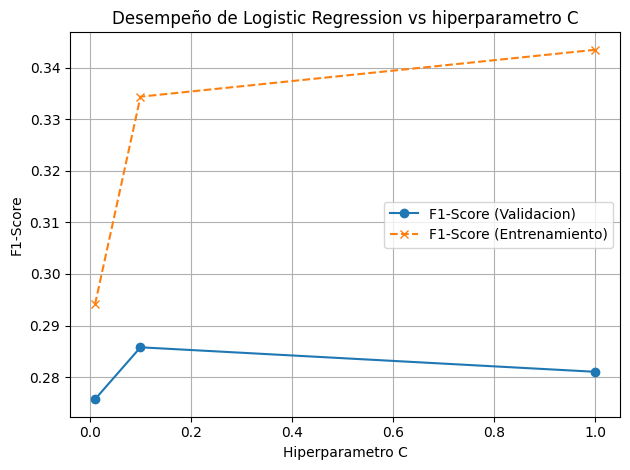

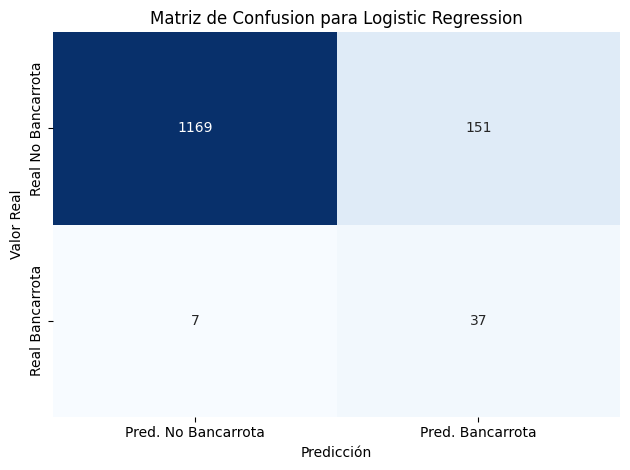

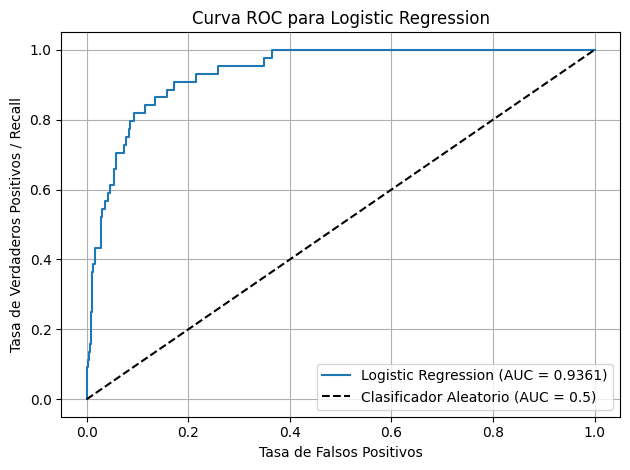


Modelo K-Nearest Neighbors:

  Mejores hiperparametros para K-Nearest Neighbors:
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}

Tabla de desempeño del modelo usando validacion cruzada:
Conjunto de Datos F1-Score (promedio ± desviacion / valor) ROC AUC Precisión Recall Accuracy
   Entrenamiento                           0.587 ± 0.02598                                  
      Validación                           0.312 ± 0.02927                                  
           Prueba                                   0.3616  0.8481    0.2406 0.7273   0.9172


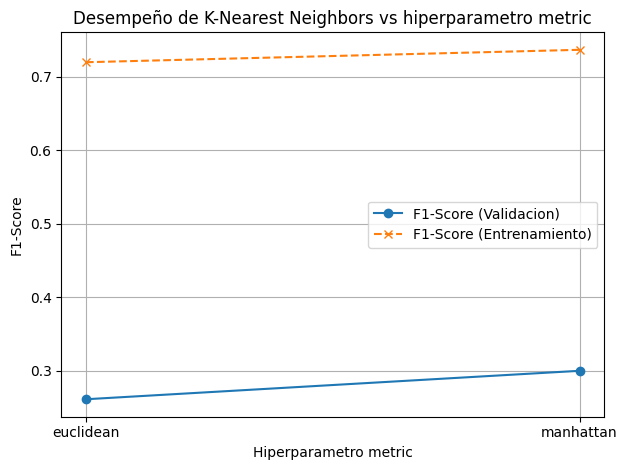

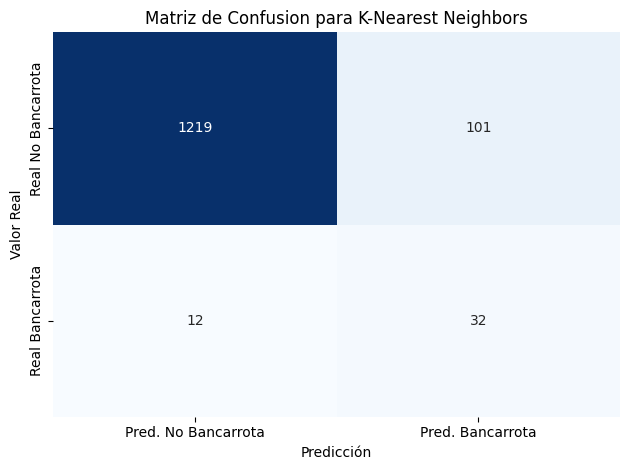

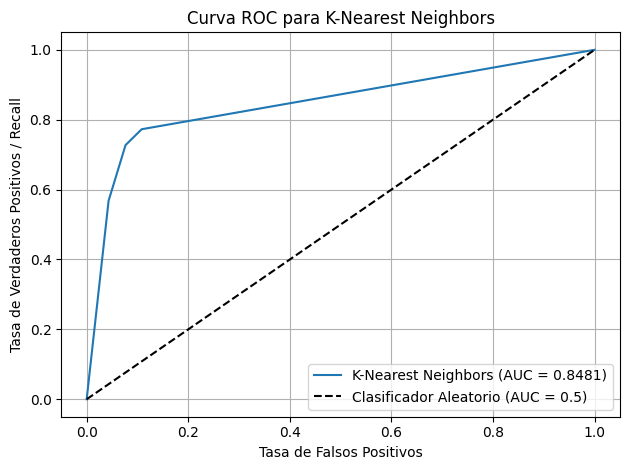


Modelo Random Forest:

  Mejores hiperparametros para Random Forest:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 20, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Tabla de desempeño del modelo usando validacion cruzada:
Conjunto de Datos F1-Score (promedio ± desviacion / valor) ROC AUC Precisión Recall Accuracy
   Entrenamiento                          0.9806 ± 0.01145                                  
      Validación                          0.4206 ± 0.04305                                  
           Prueba                                   0.4727  0.9389    0.3939 0.5909   0.9575


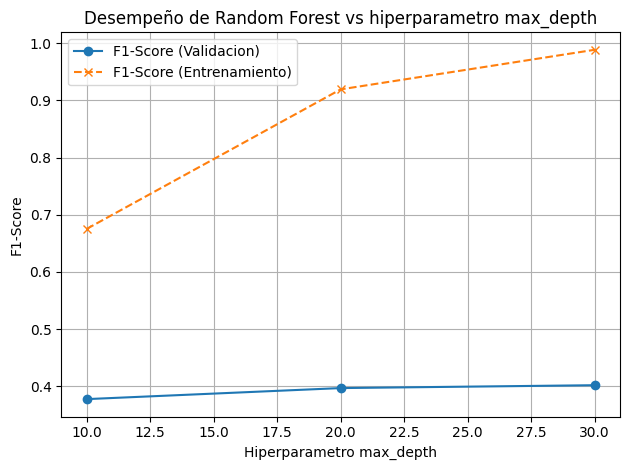

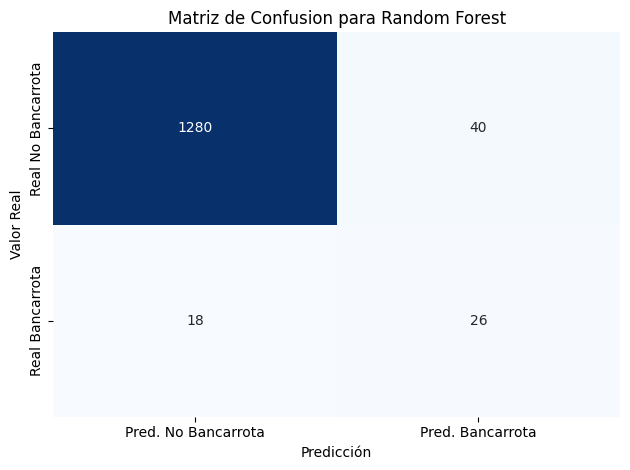

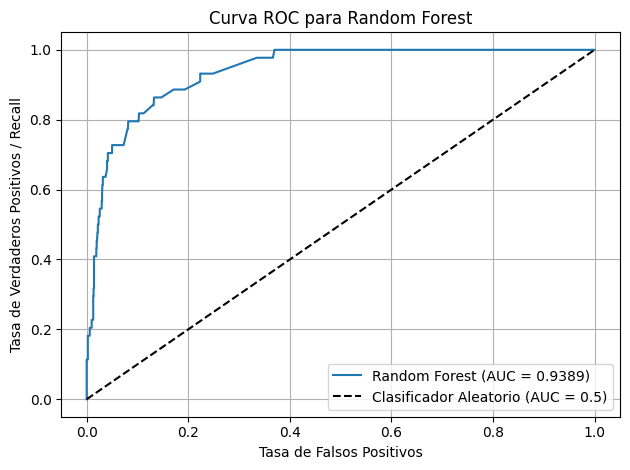


Modelo MLP Classifier:

  Mejores hiperparametros para MLP Classifier:
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (64,), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_fun': 15000, 'max_iter': 100, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}

Tabla de desempeño del modelo usando validacion cruzada:
Conjunto de Datos F1-Score (promedio ± desviacion / valor) ROC AUC Precisión Recall Accuracy
   Entrenamiento                                 1.0 ± 0.0                                  
      Validación                          0.3543 ± 0.03599                                  
           Prueba                                   0.3953  0.8289    0.4048 0.3864   0.9619


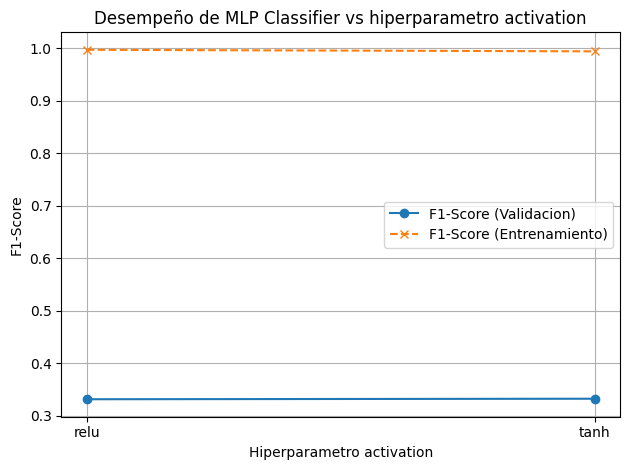

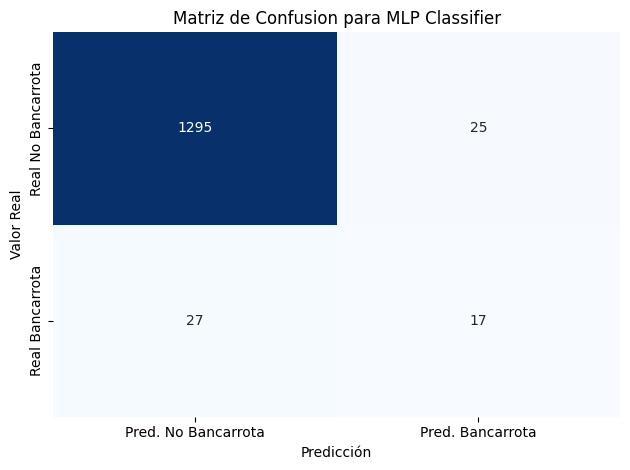

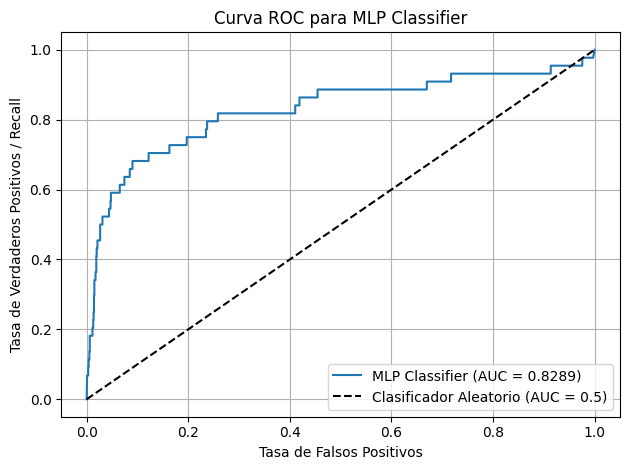


Modelo Gradient Boosting:

  Mejores hiperparametros para Gradient Boosting:
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.8, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

Tabla de desempeño del modelo usando validacion cruzada:
Conjunto de Datos F1-Score (promedio ± desviacion / valor) ROC AUC Precisión Recall Accuracy
   Entrenamiento                          0.7633 ± 0.01689                                  
      Validación                          0.3875 ± 0.02993                                  
           Prueba                                   0.4341  0.9454    0.3294 0.6364   0.9465


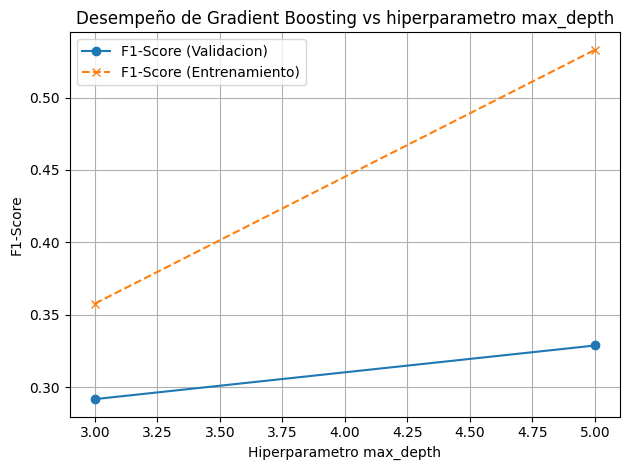

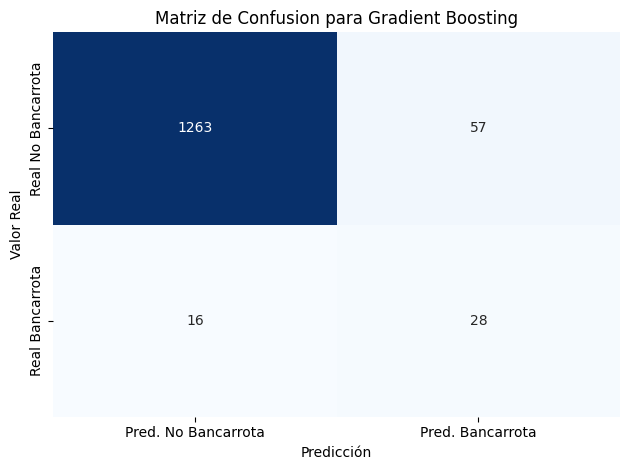

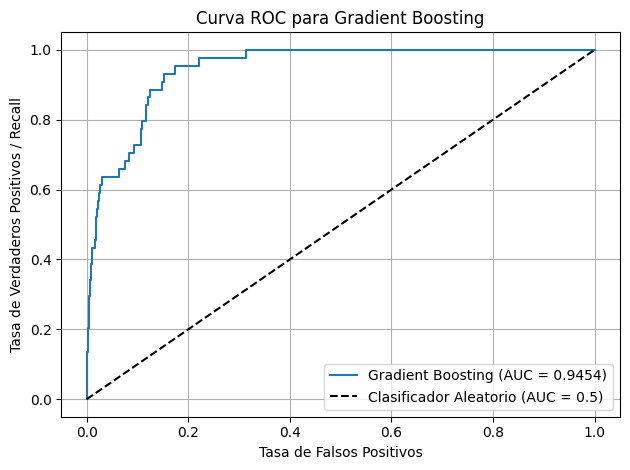


Modelo Support Vector Machine:

  Mejores hiperparametros para Support Vector Machine:
{'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': 100, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Tabla de desempeño del modelo usando validacion cruzada:
Conjunto de Datos F1-Score (promedio ± desviacion / valor) ROC AUC Precisión Recall Accuracy
   Entrenamiento                            0.1116 ± 0.065                                  
      Validación                          0.1075 ± 0.07126                                  
           Prueba                                  0.09799  0.8034   0.05186 0.8864   0.4736


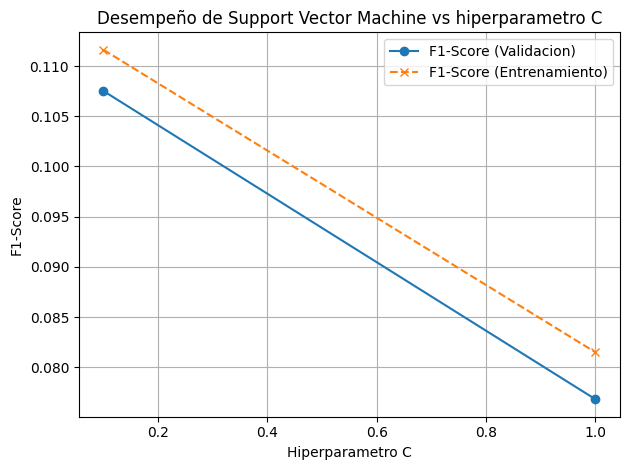

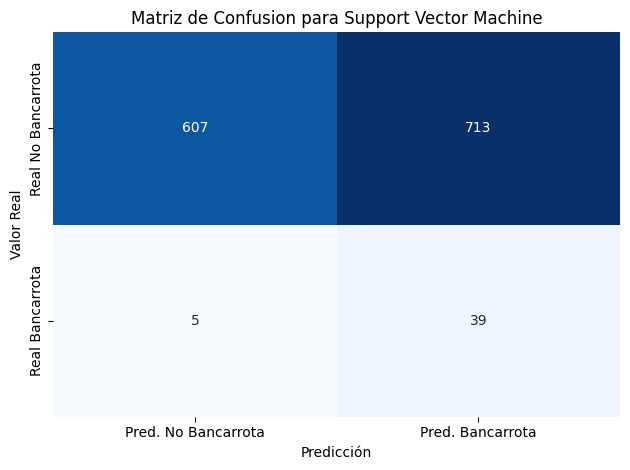

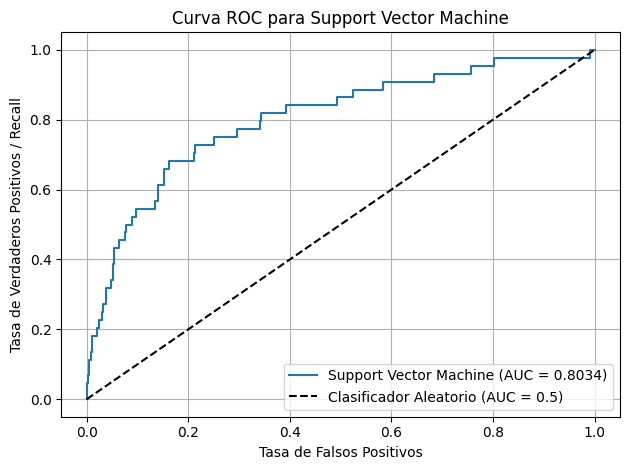


Tabla Comparativa de Modelos
                        Accuracy  Precision    Recall  F1-Score   ROC AUC
Model                                                                    
Random Forest           0.957478   0.393939  0.590909  0.472727  0.938895
Gradient Boosting       0.946481   0.329412  0.636364  0.434109  0.945351
MLP Classifier          0.961877   0.404762  0.386364  0.395349  0.828934
K-Nearest Neighbors     0.917155   0.240602  0.727273  0.361582  0.848063
Logistic Regression     0.884164   0.196809  0.840909  0.318966  0.936054
Support Vector Machine  0.473607   0.051862  0.886364  0.097990  0.803426


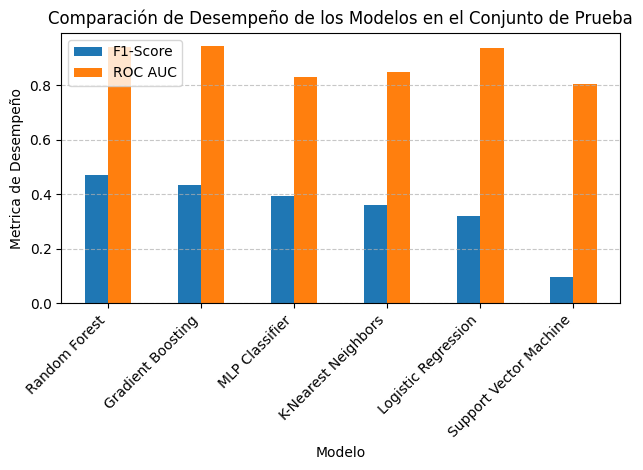

In [ ]:
# Convertir resultados del test a dataframe para facilitar la visualización
test_resultado_df = pd.DataFrame(test_resultados).set_index('Model')

for model_name, config in models_params.items():
  # visualizar cada modelo
  print(f"\nModelo {model_name}:")
  best_estimator = mejor_estimaciones[model_name]

  # Mostrar los mejores hiperparámetros encontrados
  print(f"\n  Mejores hiperparametros para {model_name}:")
  print(best_estimator.named_steps['classifier'].get_params())


  # obtenemos resultados de validación cruzada para el mejor modelo
  mejor_idx_for_model = grid_search_results[
    (grid_search_results['rank_test_score'] == 1) &
    (grid_search_results['model_name'] == model_name)
  ].index[0]
  row_cv_results = grid_search_results.loc[mejor_idx_for_model]

  # Metricas de entrenamiento y validación
  # mean_score es el score f1-score de entrenamiento promedio de los folds para el mejor modelo
  train_f1_mean = row_cv_results['mean_train_score'] # media
  train_f1_std = row_cv_results['std_train_score'] # desviacion
  val_f1_mean = row_cv_results['mean_test_score'] # media
  val_f1_std = row_cv_results['std_test_score'] # desviacion

  # Desempeño en Test
  test_data_row = test_resultado_df.loc[model_name]
  performance_table = pd.DataFrame({
    'Conjunto de Datos': ['Entrenamiento ' , 'Validación ', 'Prueba'],
    'F1-Score (promedio ± desviacion / valor)': [
      f"{train_f1_mean:.4} ± {train_f1_std:.4}",
      f"{val_f1_mean:.4} ± {val_f1_std:.4}",
      f"{test_data_row['F1-Score']:.4}"
    ],
    'ROC AUC': [
      "", # no guardamos la metricas anteriores por lo que solamente podremos visualizar los scores principales
      "",
      f"{test_data_row['ROC AUC']:.4}"
    ],
    'Precisión': [
      "",
      "",
      f"{test_data_row['Precision']:.4}"
    ],
    'Recall': [
      "",
      "",
      f"{test_data_row['Recall']:.4}"
    ],
    'Accuracy': [
      "",
      "",
      f"{test_data_row['Accuracy']:.4}"
    ]
  })
  print("\nTabla de desempeño del modelo usando validacion cruzada:")
  print(performance_table.to_string(index=False))

  # identificamos el hiperparametro mas imprtante para cada modelo con el objetivo de a hacer un visualizacion
  resultado_plot = grid_search_results[grid_search_results['model_name'] == model_name].sort_values(by='mean_test_score', ascending=False).copy()
  hiperparametros_names = [col for col in resultado_plot.columns if col.startswith('param_classifier__')]

  # Elegir el primer parámetro que tenga más de un valor único para graficar
  plot_param_name = None
  for p_name in hiperparametros_names:
    # transformamos la tubla para que sea un variable
    if resultado_plot[p_name].nunique() > 1 and not (isinstance(resultado_plot[p_name].iloc[0], tuple) and resultado_plot[p_name].nunique() > 1):
      plot_param_name = p_name
      break

  clean_plot_param_name = plot_param_name.replace('param_classifier__', '')

  # Agrupar por el parámetro para graficar promedios
  plot_df = resultado_plot.groupby(plot_param_name).agg(
    mean_test_score=('mean_test_score', 'mean'),
    mean_train_score=('mean_train_score', 'mean')
  ).reset_index()

  # convertir a cadena si es un tipo numericos o booleano para el eje X
  x_values = plot_df[plot_param_name].apply(lambda x: str(x)) if plot_df[plot_param_name].dtype == 'object' or pd.api.types.is_bool_dtype(plot_df[plot_param_name]) else plot_df[plot_param_name]

  # ordenar x_values si son numericos para una grafica coherente
  if not (plot_df[plot_param_name].dtype == 'object' or pd.api.types.is_bool_dtype(plot_df[plot_param_name])):
    plot_df = plot_df.sort_values(by=plot_param_name)
    x_values = plot_df[plot_param_name]

  # visualizacion de desempeño del modelo
  plt.plot(x_values, plot_df['mean_test_score'], marker='o', label='F1-Score (Validacion)')
  plt.plot(x_values, plot_df['mean_train_score'], marker='x', linestyle='--', label='F1-Score (Entrenamiento)')
  plt.title(f'Desempeño de {model_name} vs hiperparametro {clean_plot_param_name}')
  plt.xlabel(f'Hiperparametro {clean_plot_param_name}')
  plt.ylabel('F1-Score')
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()

  # visualizacion de matriz de confusion
  sns.heatmap(test_data_row['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', cbar=False,
              xticklabels=['Pred. No Bancarrota', 'Pred. Bancarrota'],
              yticklabels=['Real No Bancarrota', 'Real Bancarrota'])
  plt.title(f'Matriz de Confusion para {model_name}')
  plt.xlabel('Predicción')
  plt.ylabel('Valor Real')
  plt.tight_layout()
  plt.show()

  # visualizar curva roc auc
  fpr, tpr, _ = roc_curve(y_test, best_estimator.predict_proba(X_test)[:, 1])
  plt.plot(fpr, tpr, label=f'{model_name} (AUC = {test_data_row["ROC AUC"]:.4f})')
  plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio (AUC = 0.5)') # es un modelo el cual tiene la capacidad de ser correcto o equivocado
  plt.xlabel('Tasa de Falsos Positivos')
  plt.ylabel('Tasa de Verdaderos Positivos / Recall')
  plt.title(f'Curva ROC para {model_name}')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.tight_layout()
  plt.show()


print("\nTabla Comparativa de Modelos")
final_comparison_df = test_resultado_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']].copy()
final_comparison_df = final_comparison_df.sort_values(by='F1-Score', ascending=False)
print(final_comparison_df.to_string())


final_comparison_df[['F1-Score', 'ROC AUC']].plot(kind='bar')
plt.title('Comparación de Desempeño de los Modelos en el Conjunto de Prueba')
plt.xlabel('Modelo')
plt.ylabel('Metrica de Desempeño')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Identificacion y seleccion de los 2 mejores modelos

In [ ]:
# Ordenar los modelos por f1-score y roc auc, obtener sus nombres y visualizacion de los mismos
sorted_models = test_resultado_df.sort_values(by=['F1-Score', 'ROC AUC'], ascending=[False, False])
top_2_models_names = sorted_models.index[:2].tolist()
top_2_models_info = sorted_models.head(2)
print(top_2_models_info.to_string())

# guardamos los pipelines completos de los mejores modelos
top_2_best_estimators = {name: mejor_estimaciones[name] for name in top_2_models_names}

                   Accuracy  Precision    Recall  F1-Score   ROC AUC        Confusion Matrix
Model                                                                                       
Random Forest      0.957478   0.393939  0.590909  0.472727  0.938895  [[1280, 40], [18, 26]]
Gradient Boosting  0.946481   0.329412  0.636364  0.434109  0.945351  [[1263, 57], [16, 28]]


# Analisis de correlacion y varianza para las caracteristicas

In [ ]:
X_train_val_copy = X_train_val.copy() # Copia para no modificar X_train_val
X_train_val_copy['objetivo'] = y_train_val.values # Asignamos el nombre 'objetivo' directamente a los y_train_val

# Analisis de Correlacion para ver relaciones lineales con la variable objetivo
correlations = X_train_val_copy.corr()['objetivo'].sort_values(key=abs, ascending=False)
print(f"\nCorrelación de Pearson de cada característica con la variable objetivo 'objetivo':")
print(correlations.to_string())

# Identificar características con muy baja correlación
umbral_corr = 0.01 # Umbral de correlación
print(f"\n\nCaracterísticas candidatas a ser eliminadas por tener una correlación (Pearson) muy baja (< {umbral_corr}) con la variable objetivo:")
print(correlations[abs(correlations) < umbral_corr].to_string())


Correlación de Pearson de cada característica con la variable objetivo 'objetivo':
objetivo                                                    1.000000
 Net Income to Total Assets                                -0.316354
 ROA(A) before interest and % after tax                    -0.283811
 ROA(B) before interest and depreciation after tax         -0.275219
 ROA(C) before interest and depreciation before interest   -0.262665
 Net worth/Assets                                          -0.247642
 Debt ratio %                                               0.247642
 Persistent EPS in the Last Four Seasons                   -0.221009
 Retained Earnings to Total Assets                         -0.213839
 Net Income to Stockholder's Equity                        -0.206648
 Net profit before tax/Paid-in capital                     -0.206277
 Per Share Net profit before tax (Yuan ¥)                  -0.205256
 Borrowing dependency                                       0.196911
 Current Liability 

In [ ]:
# Análisis de Varianza buscando la característica que prensenta valor constante para todas las muestras
print("\nAnálisis de Varianza")
variances = X_train_val.var()
print(variances)
umbral_varianza = 1e-3 # Umbral para varianza cercana a cero (ajustable)
print(f"\n  Caracteristicas candidatas a ser eliminadas por tener varianza < {umbral_varianza}:")
print(variances[variances < umbral_varianza].to_string())


Análisis de Varianza
ROA(C) before interest and depreciation before interest    0.003643
ROA(A) before interest and % after tax                     0.004271
ROA(B) before interest and depreciation after tax          0.003770
Operating Gross Margin                                     0.000291
Realized Sales Gross Margin                                0.000290
                                                             ...   
Liability to Equity                                        0.000191
Degree of Financial Leverage (DFL)                         0.000302
Interest Coverage Ratio (Interest expense to EBIT)         0.000205
Net Income Flag                                            0.000000
Equity to Liability                                        0.002405
Length: 95, dtype: float64

  Caracteristicas candidatas a ser eliminadas por tener varianza < 0.001:
Operating Gross Margin                                0.000291
Realized Sales Gross Margin                           0.000290
Op

# Selección de Características por Búsqueda Secuencial Ascendente

In [ ]:
# # definir el clasificador base para SFS
# base_model_name = top_2_models_names[0]
# base_model_pipeline = top_2_best_estimators[base_model_name]

# # Crear un pipeline simplificado para SFS
# sfs_pipeline_base = ImbPipeline([
#   ('scaler', StandardScaler()),
#   ('classifier', clone(base_model_pipeline.named_steps['classifier'])) # Clonar solo el clasificador
# ])
# # seleccionamos solamente el 90% de las caracteristicas
# criterion = 'f1'
# n_features = int(X_train_val.shape[1] * 0.9)

# print(f"\nIniciando de Sequential Feature Selector para el modelo: {base_model_name}")
# print(f"Numero de caracteristicas a seleccionar: {n_features}")

# sfs = SequentialFeatureSelector(
#   estimator=sfs_pipeline_base,
#   n_features_to_select=n_features,
#   direction='forward', # direccion
#   scoring=criterion,
#   cv=stratified_kfold,
#   n_jobs=-1
# )

# sfs.fit(X_train_val, y_train_val)

# # Obtener las características seleccionadas
# selected_features_names = X_train_val.columns[sfs.get_support()].tolist()
# feature_count = X_train_val.shape[1]
# feature_count_reducido = len(selected_features_names)
# porcentaje = (1 - (feature_count_reducido / feature_count)) * 100

# print(f"\nResultados de Caracteristicas {base_model_name}")
# print(f"Criterio de seleccion: {criterion.upper()}")
# print(f"Numero de caracteristicas iniciales: {feature_count}")
# print(f"Numero de caracteristicas seleccionadas: {feature_count_reducido}")
# print(f"Porcentaje de reducción de características: {porcentaje:.2f}%")
# print(f"Características seleccionadas: {selected_features_names}")

# selected_features_sfs = selected_features_names
# sfs_reduction_percentage = porcentaje # Almacenar para la tabla de resultados

In [ ]:
# limpieza de datos para eliminar características que son constantes o casi constantes por baja varianza.
variances = X_train_val.var()
features_eliminadas_varianza = variances[variances < umbral_varianza].index.tolist()
X_train_val_eliminada_varianza = X_train_val.drop(columns=features_eliminadas_varianza, errors='ignore').copy()

seleccion_features_sfs = X_train_val_eliminada_varianza.columns.tolist()
feature_count = X_train_val.shape[1]
feature_count_reducido = len(seleccion_features_sfs)
porcentaje = (1 - (feature_count_reducido / feature_count)) * 100

print(f"\nResultados de Caracteristicas\nCriterio de seleccion: f1")
print(f"Numero de caracteristicas iniciales: {feature_count}")
print(f"Numero de caracteristicas seleccionadas: {feature_count_reducido}")
print(f"Porcentaje de reducción de características: {porcentaje:.2f}%")
print(f"Características seleccionadas: {seleccion_features_sfs}")


Resultados de Caracteristicas
Criterio de seleccion: f1
Numero de caracteristicas iniciales: 95
Numero de caracteristicas seleccionadas: 44
Porcentaje de reducción de características: 53.68%
Características seleccionadas: [' ROA(C) before interest and depreciation before interest', ' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Operating Expense Rate', ' Research and development expense rate', ' Interest-bearing debt interest rate', ' Tax rate (A)', ' Persistent EPS in the Last Four Seasons', ' Revenue Per Share (Yuan ¥)', ' Total Asset Growth Rate', ' Net Value Growth Rate', ' Quick Ratio', ' Total debt/Total net worth', ' Debt ratio %', ' Net worth/Assets', ' Total Asset Turnover', ' Accounts Receivable Turnover', ' Average Collection Days', ' Inventory Turnover Rate (times)', ' Fixed Assets Turnover Frequency', ' Net Worth Turnover Rate (times)', ' Revenue per person', ' Allocation rate per person', ' Working Capital to Total Asse

# Re entrenamiento del modelo con Caracteristicas Seleccionadas por SFS

In [ ]:
X_train_val_sfs = X_train_val[seleccion_features_sfs].copy()
X_test_sfs = X_test[seleccion_features_sfs].copy()

print(f"\nDatos de entrenamiento y validacion con SFS: {X_train_val_sfs.shape} (original: {X_train_val.shape})")
print(f"Datos de prueba con SFS: {X_test_sfs.shape}")
print(f"Caracteristicas seleccionadas por SFS ({len(seleccion_features_sfs)}): {seleccion_features_sfs}")

# Nueva las listas para almacenar resultados
sfs_test_resultado = []

for model_name in top_2_models_names:
  print(f"\nNuevo entrenamiento de {model_name} con reduccion de caracteristicas")

  # obtener la configuracion original del modelo
  model_config = models_params[model_name]

  # crear un nuevo pipeline identico al original
  pipeline_sfs = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', clone(model_config['model'])) # clonar el modelo para tener un nuevo estado
  ])

  grid_search_sfs = GridSearchCV(
    estimator=pipeline_sfs,
    param_grid=model_config['param_grid'], # Usar los mismos de hiperparametros
    cv=stratified_kfold,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
  )

  # Entrenar y evaluar el modelo con los datos filtrados por SFS
  grid_search_sfs.fit(X_train_val_sfs, y_train_val)
  y_pred_sfs = grid_search_sfs.best_estimator_.predict(X_test_sfs)
  y_proba_sfs = grid_search_sfs.best_estimator_.predict_proba(X_test_sfs)[:, 1]

  acc = accuracy_score(y_test, y_pred_sfs)
  prec = precision_score(y_test, y_pred_sfs)
  rec = recall_score(y_test, y_pred_sfs)
  f1 = f1_score(y_test, y_pred_sfs)
  roc_auc = roc_auc_score(y_test, y_proba_sfs)

  sfs_test_resultado.append({
    'Model': model_name,
    'Method': 'SFS',
    'Reduction_Perc': porcentaje,
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    'ROC AUC': roc_auc,
    'Confusion Matrix': confusion_matrix(y_test, y_pred_sfs),
    'Best Params': grid_search_sfs.best_params_,
    'Best CV F1': grid_search_sfs.best_score_
  })

  print(f"  Mejor F1-Score CV para {model_name} (SFS): {grid_search_sfs.best_score_:.4f}")
  print(f"  F1-Score en Test para {model_name} (SFS): {f1:.4f}")
  print(f"  ROC AUC en Test para {model_name} (SFS): {roc_auc:.4f}")

# Convertir a dataframe para la tabla final
sfs_resultados_df = pd.DataFrame(sfs_test_resultado).set_index('Model')


Datos de entrenamiento y validacion con SFS: (5455, 44) (original: (5455, 95))
Datos de prueba con SFS: (1364, 44)
Caracteristicas seleccionadas por SFS (44): [' ROA(C) before interest and depreciation before interest', ' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Operating Expense Rate', ' Research and development expense rate', ' Interest-bearing debt interest rate', ' Tax rate (A)', ' Persistent EPS in the Last Four Seasons', ' Revenue Per Share (Yuan ¥)', ' Total Asset Growth Rate', ' Net Value Growth Rate', ' Quick Ratio', ' Total debt/Total net worth', ' Debt ratio %', ' Net worth/Assets', ' Total Asset Turnover', ' Accounts Receivable Turnover', ' Average Collection Days', ' Inventory Turnover Rate (times)', ' Fixed Assets Turnover Frequency', ' Net Worth Turnover Rate (times)', ' Revenue per person', ' Allocation rate per person', ' Working Capital to Total Assets', ' Quick Assets/Total Assets', ' Current Assets/Total Asset

# Extracción de Características con PCA


Se seleccionaron 50 componentes principales para explicar el 95% de la varianza con una reducción de 47.3684


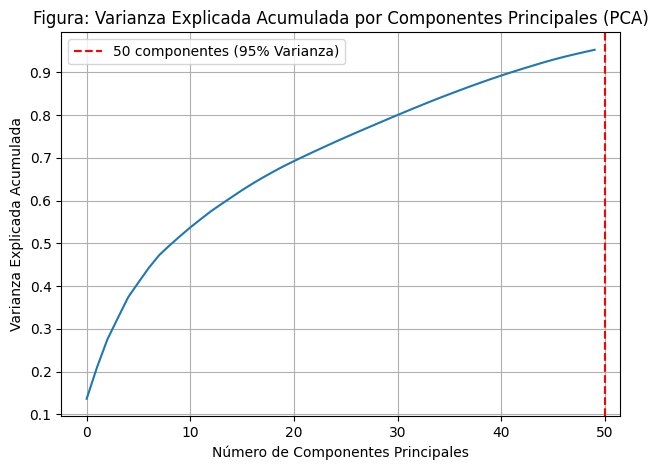

Datos de entrenamiento/validación transformados por PCA: (5455, 50)
Datos de prueba transformados por PCA: (1364, 50)

Nuevo entrenamiento de Random Forest con PCA
Fitting 5 folds for each of 36 candidates, totalling 180 fits
  Mejor F1-Score CV para Random Forest (PCA): 0.3630
  F1-Score en Test para Random Forest (PCA): 0.3551
  ROC AUC en Test para Random Forest (PCA): 0.9036

Nuevo entrenamiento de Gradient Boosting con PCA
Fitting 5 folds for each of 16 candidates, totalling 80 fits
  Mejor F1-Score CV para Gradient Boosting (PCA): 0.3124
  F1-Score en Test para Gradient Boosting (PCA): 0.3699
  ROC AUC en Test para Gradient Boosting (PCA): 0.9137


In [ ]:
# debido a que PCA es sensible se aplica un escalado a la escalamiento de las caraacteristicas
scaler_pca = StandardScaler()
X_train_val_scaled_for_pca = scaler_pca.fit_transform(X_train_val)
X_test_scaled_for_pca = scaler_pca.transform(X_test)

# capturaremos el 95% de la varianza explicada
pca = PCA(n_components=0.95, random_state=42)
pca.fit(X_train_val_scaled_for_pca) # Ajustar PCA solo en los datos de entrenamiento/validación escalados

n_components_pca = pca.n_components_
porcentaje = (1 - (n_components_pca / X_train_val.shape[1])) * 100
print(f"\nSe seleccionaron {n_components_pca} componentes principales para explicar el 95% de la varianza con una reducción de {porcentaje:.4f}")

# Visualizar la varianza explicada
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Figura: Varianza Explicada Acumulada por Componentes Principales (PCA)')
plt.grid(True)
plt.axvline(x=n_components_pca, color='r', linestyle='--', label=f'{n_components_pca} componentes (95% Varianza)')
plt.legend()
plt.tight_layout()
plt.show()

# Transformar los datos a los nuevos componentes principales
X_train_val_pca = pca.transform(X_train_val_scaled_for_pca)
X_test_pca = pca.transform(X_test_scaled_for_pca)

print(f"Datos de entrenamiento/validación transformados por PCA: {X_train_val_pca.shape}")
print(f"Datos de prueba transformados por PCA: {X_test_pca.shape}")

# Re-evaluar los 2 mejores modelos con los componentes PCA
pca_test_resultado = []

for model_name in top_2_models_names:
    print(f"\nNuevo entrenamiento de {model_name} con PCA")

    # obtener la configuracion original del modelo
    model_config = models_params[model_name]

    # crear un nuevo pipeline identico al original pero con la ejecucion del PCA
    pipeline_pca = ImbPipeline([
      ('scaler', StandardScaler()),
      ('pca', PCA(n_components=n_components_pca, random_state=42)),
      ('smote', SMOTE(random_state=42)),
      ('classifier', clone(model_config['model']))
    ])


    grid_search_pca = GridSearchCV(
      estimator=pipeline_pca,
      param_grid=model_config['param_grid'], # Usar los mismos de hiperparametros
      cv=stratified_kfold,
      scoring='f1',
      n_jobs=-1,
      verbose=1,
      return_train_score=True
    )

    # Entrenar el modelo con los datos originales
    grid_search_pca.fit(X_train_val, y_train_val)

    # Evaluar en el conjunto de prueba final
    y_pred_pca = grid_search_pca.best_estimator_.predict(X_test)
    y_proba_pca = grid_search_pca.best_estimator_.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred_pca)
    prec = precision_score(y_test, y_pred_pca)
    rec = recall_score(y_test, y_pred_pca)
    f1 = f1_score(y_test, y_pred_pca)
    roc_auc = roc_auc_score(y_test, y_proba_pca)

    pca_test_resultado.append({
        'Model': model_name,
        'Method': 'PCA',
        'Reduction_Perc': porcentaje,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC AUC': roc_auc,
        'Confusion Matrix': confusion_matrix(y_test, y_pred_pca),
        'Best Params': grid_search_pca.best_params_,
        'Best CV F1': grid_search_pca.best_score_
    })

    print(f"  Mejor F1-Score CV para {model_name} (PCA): {grid_search_pca.best_score_:.4f}")
    print(f"  F1-Score en Test para {model_name} (PCA): {f1:.4f}")
    print(f"  ROC AUC en Test para {model_name} (PCA): {roc_auc:.4f}")

# Convertir a dataframe para acceso a la tabla final
pca_results_df = pd.DataFrame(pca_test_resultado).set_index('Model')

# Analisis y Comparacion Final de Todos los Resultados


Tabla Comparativa de Desempeño (Original, SFS, PCA)
            Model  F1-Score  ROC AUC  Precision   Recall  Accuracy  Method  Reduction_Perc
Gradient Boosting  0.434109 0.945351   0.329412 0.636364  0.946481 control        0.000000
Gradient Boosting  0.429530 0.928512   0.304762 0.727273  0.937683     SFS       53.684211
Gradient Boosting  0.369863 0.913654   0.264706 0.613636  0.932551     PCA       47.368421
    Random Forest  0.474576 0.924148   0.378378 0.636364  0.954545     SFS       53.684211
    Random Forest  0.472727 0.938895   0.393939 0.590909  0.957478 control        0.000000
    Random Forest  0.355140 0.903624   0.301587 0.431818  0.949413     PCA       47.368421


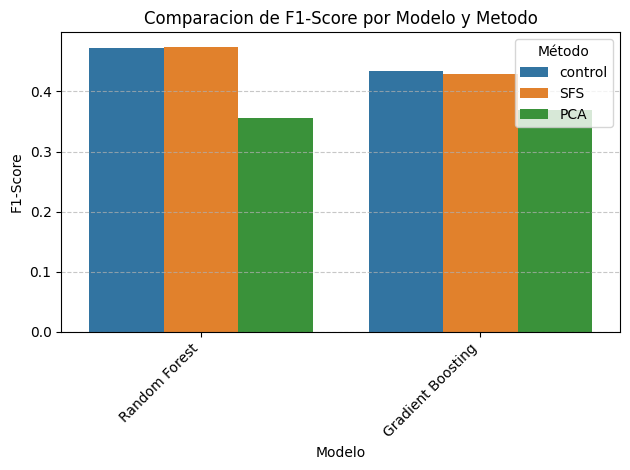

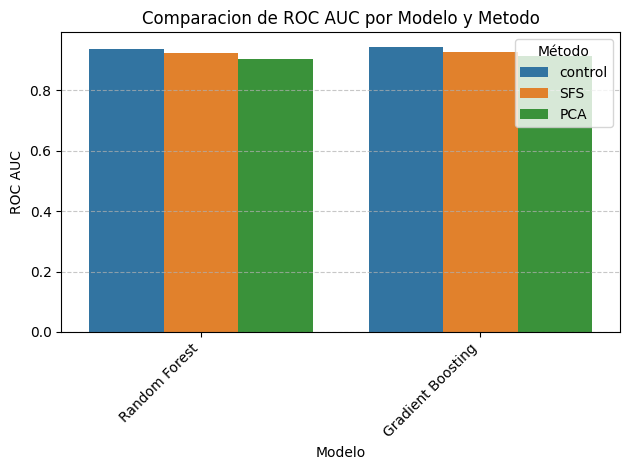

In [ ]:
# Preparar los DataFrames para la unión
# Añadir una columna 'metodo' para usarlo como indicador de operacion
original_results = test_resultado_df.loc[top_2_models_names].copy() # Solo los 2 mejores modelos originales
original_results['Method'] = 'control'
original_results['Reduction_Perc'] = 0.0 # No hay reduccion de caracteriticas en el modelo original

sfs_results = sfs_resultados_df.copy()
pca_results = pca_results_df.copy()

# seleccionar solo las columnas de metricas que queremos comparar
cols_to_compare = ['F1-Score', 'ROC AUC', 'Precision', 'Recall', 'Accuracy', 'Method', 'Reduction_Perc']
df_original = original_results[cols_to_compare].reset_index().rename(columns={'index': 'Model'})
df_sfs = sfs_results[cols_to_compare].reset_index().rename(columns={'index': 'Model'})
df_pca = pca_results[cols_to_compare].reset_index().rename(columns={'index': 'Model'})


# concatenar todos los resultados para la comparación final
all_results_comparison = pd.concat([df_original, df_sfs, df_pca], ignore_index=True)

# ordenar para una mejor visualización
all_results_comparison_sorted = all_results_comparison.sort_values(by=['Model', 'F1-Score'], ascending=[True, False])

print("\nTabla Comparativa de Desempeño (Original, SFS, PCA)")
print(all_results_comparison_sorted.to_string(index=False))


# grafico de f1-Score por modelo y metodo
sns.barplot(data=all_results_comparison, x='Model', y='F1-Score', hue='Method')
plt.title('Comparacion de F1-Score por Modelo y Metodo')
plt.xlabel('Modelo')
plt.ylabel('F1-Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Método')
plt.tight_layout()
plt.show()

# grafico de roc auc por modelo y metodo
sns.barplot(data=all_results_comparison, x='Model', y='ROC AUC', hue='Method')
plt.title('Comparacion de ROC AUC por Modelo y Metodo')
plt.xlabel('Modelo')
plt.ylabel('ROC AUC')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Método')
plt.tight_layout()
plt.show()

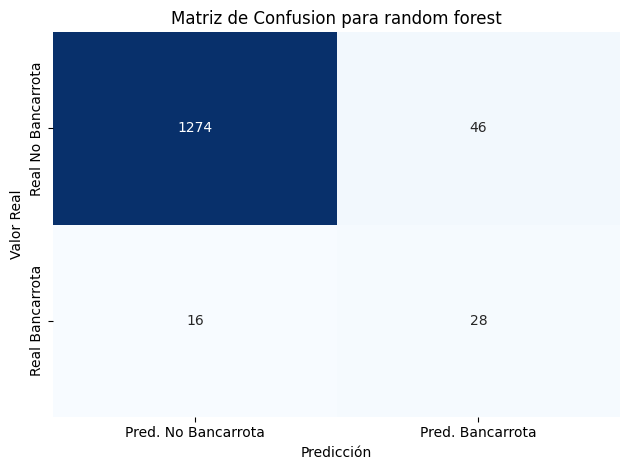

In [ ]:
sns.heatmap(sfs_results['Confusion Matrix']['Random Forest'], annot=True, fmt='d', cmap='Blues', cbar=False,
  xticklabels=['Pred. No Bancarrota', 'Pred. Bancarrota'],
  yticklabels=['Real No Bancarrota', 'Real Bancarrota'])
plt.title('Matriz de Confusion para random forest')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()